In [1]:
# import required packages

import torch
import torch.nn as nn 
import numpy as np 
from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [2]:
# configuration
dataset_path = './assets/'
use_gpu = True 

# Check that MPS is available
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")
    device = torch.device("cpu")
    print("Using CPU as device")
else:
    device = torch.device("mps")
    print("Using MPS as device")
    
torch.set_default_device(device)


# model parameters
epochs = 100

x_dim = 28 * 28 
hidden_dim = 400 # hidden vector for encoder and decoder
latent_dim = 200 # latent vector for output of encoder, input of decoder

init_lr = 1e-3

batch_size = 100

Using MPS as device


In [3]:
from torchvision.datasets import MNIST 
import torchvision.transforms as transforms 
from torch.utils.data import DataLoader 

# define a dataset, and dataset loader
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, generator= torch.Generator(device=device))
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, generator= torch.Generator(device=device))


In [4]:
# Defining the Variational Auto Encoder(VAE)

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC1 = nn.Linear(input_dim, hidden_dim)
        self.FC2 = nn.Linear(hidden_dim, hidden_dim)
        self.output_mean = nn.Linear(hidden_dim, latent_dim)
        self.output_log_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True 

    def forward(self, x):
        hidden = self.LeakyReLU(self.FC1(x))
        hidden = self.LeakyReLU(self.FC2(hidden))
        mean = self.output_mean(hidden)
        log_var = self.output_log_var(hidden)

        return mean, log_var
        

In [5]:
# Defining the Decoder for VAE 

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC1 = nn.Linear(latent_dim, hidden_dim)
        self.FC2 = nn.Linear(hidden_dim, hidden_dim)
        self.Output = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, z):
        hidden = self.LeakyReLU(self.FC1(z))
        hidden = self.LeakyReLU(self.FC2(hidden))

        # scale the element's output to 0~1
        x = torch.sigmoid(self.Output(hidden))

        return x

In [6]:
# Define overall model: Encoder + Decoder 

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder 
        self.Decoder = Decoder 
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var * epsilon
        return z

    def forward(self, x):
        mean, log_var = self.Encoder(x)

        # since encoder outputs log(var), we have to convert into var
        z = self.reparameterization(mean, torch.exp(0.5 * log_var))

        x_hat = self.Decoder(z)

        return x_hat, mean, log_var

In [7]:
# setup instance of encoder, decoder, model 
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(device)

In [8]:
# Define the training objective(=Loss function)
from torch.optim import Adam 

BCE = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [9]:
# Define an optimizer 

optimizer = Adam(model.parameters(), lr = init_lr)

In [10]:
# Train the VAE 

def train_epoch(epoch_idx, tb_writer):
    running_loss = 0. 
    last_loss = 0.

    for batch_idx, (x, _) in enumerate(train_loader): 
        x = x.view(batch_size, x_dim)
        x = x.to(device)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)

        loss.backward()

        # adjust learning weights 
        optimizer.step()

        running_loss += loss.item()

        if batch_idx % 10 == 9: 
            last_loss = running_loss / 10 # loss per batch 
            # print(f'batch {batch_idx + 1} loss: {last_loss}')

            tb_x = epoch_idx * len(train_loader) + batch_idx + 1 
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0. 
            
    return last_loss 
        

In [12]:
# Real training happens at this cell 
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

best_vloss = 1_000_000. 

for epoch in range(epochs):
    print(f'EPOCH {epoch + 1}:')

    # make sure gradient tracking is on 
    model.train(True)

    # train the model 
    avg_loss = train_epoch(epoch, writer)

    running_vloss = 0.0 

    # turn on the evaluation mode. Wich disable dropout 
    model.eval()
    # Disable gradient computation to reduce perf. overhead 
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
            x = x.view(batch_size, x_dim)
            x = x.to(device)
            x_hat, mean, log_var = model(x) 

            vloss = loss_function(x, x_hat, mean, log_var)
            running_vloss += vloss 
            
    avg_vloss = running_vloss / (batch_idx + 1) 

    print(f'Loss train {avg_loss} valid {avg_vloss}')

    if avg_vloss < best_vloss:
        best_vloss = avg_vloss 
        model_path = f'models/model_{timestamp}_{epoch}'
        torch.save(model.state_dict(), model_path)

EPOCH 1:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.95it/s]


Loss train 12122.92333984375 valid 11932.6787109375
EPOCH 2:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 255.58it/s]


Loss train 11572.4951171875 valid 11356.513671875
EPOCH 3:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 247.15it/s]


Loss train 11253.2189453125 valid 11035.5703125
EPOCH 4:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 255.03it/s]


Loss train 10945.5353515625 valid 10806.9453125
EPOCH 5:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 251.74it/s]


Loss train 10791.9783203125 valid 10666.978515625
EPOCH 6:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.74it/s]


Loss train 10655.517578125 valid 10588.2421875
EPOCH 7:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 254.52it/s]


Loss train 10580.2931640625 valid 10489.2783203125
EPOCH 8:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 236.15it/s]


Loss train 10499.99970703125 valid 10464.025390625
EPOCH 9:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 252.09it/s]


Loss train 10403.2416015625 valid 10417.0185546875
EPOCH 10:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.60it/s]


Loss train 10636.48134765625 valid 10389.4716796875
EPOCH 11:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 257.05it/s]


Loss train 10274.8888671875 valid 10304.94140625
EPOCH 12:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 254.99it/s]


Loss train 10321.40546875 valid 10279.375
EPOCH 13:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 252.56it/s]


Loss train 10386.96923828125 valid 10271.8115234375
EPOCH 14:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 253.89it/s]


Loss train 10240.36806640625 valid 10251.6396484375
EPOCH 15:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 253.55it/s]


Loss train 10196.7068359375 valid 10204.3701171875
EPOCH 16:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 249.85it/s]


Loss train 10225.86953125 valid 10192.404296875
EPOCH 17:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 252.86it/s]


Loss train 10269.63759765625 valid 10182.0126953125
EPOCH 18:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 251.73it/s]


Loss train 10178.67607421875 valid 10161.4697265625
EPOCH 19:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 252.22it/s]


Loss train 10202.3072265625 valid 10152.1142578125
EPOCH 20:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 251.60it/s]


Loss train 10039.457421875 valid 10108.9638671875
EPOCH 21:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 254.00it/s]


Loss train 10222.2205078125 valid 10133.294921875
EPOCH 22:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.08it/s]


Loss train 10054.96826171875 valid 10124.8603515625
EPOCH 23:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 255.31it/s]


Loss train 10118.7830078125 valid 10107.962890625
EPOCH 24:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 255.55it/s]


Loss train 10184.96142578125 valid 10095.646484375
EPOCH 25:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 254.03it/s]


Loss train 10142.1009765625 valid 10083.017578125
EPOCH 26:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 248.02it/s]


Loss train 10122.77802734375 valid 10044.9072265625
EPOCH 27:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 255.23it/s]


Loss train 9971.94873046875 valid 10063.7666015625
EPOCH 28:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 257.35it/s]


Loss train 10171.210546875 valid 10064.0615234375
EPOCH 29:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.08it/s]


Loss train 10132.90205078125 valid 10048.4541015625
EPOCH 30:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.31it/s]


Loss train 10024.6453125 valid 10050.541015625
EPOCH 31:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.10it/s]


Loss train 10187.42470703125 valid 10034.39453125
EPOCH 32:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.52it/s]


Loss train 9944.19541015625 valid 10039.8251953125
EPOCH 33:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.72it/s]


Loss train 9962.79423828125 valid 10017.130859375
EPOCH 34:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.31it/s]


Loss train 9947.7908203125 valid 10000.4248046875
EPOCH 35:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.31it/s]


Loss train 9901.34814453125 valid 9984.41015625
EPOCH 36:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.85it/s]


Loss train 9852.34287109375 valid 9998.3564453125
EPOCH 37:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.86it/s]


Loss train 9939.1416015625 valid 10009.3623046875
EPOCH 38:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.90it/s]


Loss train 9985.40830078125 valid 10003.748046875
EPOCH 39:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.70it/s]


Loss train 9984.8236328125 valid 10008.15234375
EPOCH 40:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.33it/s]


Loss train 9821.31787109375 valid 9969.494140625
EPOCH 41:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.21it/s]


Loss train 9896.2033203125 valid 9978.173828125
EPOCH 42:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.56it/s]


Loss train 9904.56904296875 valid 9979.412109375
EPOCH 43:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.69it/s]


Loss train 9926.4623046875 valid 9986.7216796875
EPOCH 44:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 261.01it/s]


Loss train 9826.61259765625 valid 9988.5771484375
EPOCH 45:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 261.29it/s]


Loss train 9894.67685546875 valid 9991.130859375
EPOCH 46:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 259.91it/s]


Loss train 9947.3078125 valid 9996.861328125
EPOCH 47:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 260.07it/s]


Loss train 9961.2671875 valid 9963.4052734375
EPOCH 48:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.53it/s]


Loss train 9891.69296875 valid 9969.5986328125
EPOCH 49:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 255.00it/s]


Loss train 9893.49599609375 valid 9958.3408203125
EPOCH 50:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.03it/s]


Loss train 9819.447265625 valid 9999.1015625
EPOCH 51:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 257.62it/s]


Loss train 9926.939453125 valid 9956.05078125
EPOCH 52:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.71it/s]


Loss train 9920.6919921875 valid 9943.9384765625
EPOCH 53:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.24it/s]


Loss train 9844.88427734375 valid 9955.6220703125
EPOCH 54:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.59it/s]


Loss train 9978.14375 valid 9950.345703125
EPOCH 55:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 247.57it/s]


Loss train 9879.2232421875 valid 9953.4521484375
EPOCH 56:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.59it/s]


Loss train 9950.06630859375 valid 9918.615234375
EPOCH 57:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.02it/s]


Loss train 9873.8173828125 valid 9964.505859375
EPOCH 58:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 257.93it/s]


Loss train 9908.77138671875 valid 9932.986328125
EPOCH 59:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.22it/s]


Loss train 9847.34541015625 valid 9926.3447265625
EPOCH 60:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.76it/s]


Loss train 10036.57646484375 valid 9928.427734375
EPOCH 61:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 257.06it/s]


Loss train 9869.40556640625 valid 9956.5888671875
EPOCH 62:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.53it/s]


Loss train 9848.50830078125 valid 9963.03125
EPOCH 63:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 256.02it/s]


Loss train 9846.24580078125 valid 9929.7763671875
EPOCH 64:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.45it/s]


Loss train 9885.75380859375 valid 9944.41015625
EPOCH 65:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 258.52it/s]


Loss train 9888.64365234375 valid 9924.7802734375
EPOCH 66:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 247.48it/s]


Loss train 9898.424609375 valid 9922.9560546875
EPOCH 67:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 254.24it/s]


Loss train 9843.67978515625 valid 9922.619140625
EPOCH 68:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 208.77it/s]


Loss train 9742.70888671875 valid 9926.07421875
EPOCH 69:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 223.33it/s]


Loss train 9839.7205078125 valid 9923.4189453125
EPOCH 70:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 251.16it/s]


Loss train 9804.69130859375 valid 9926.8291015625
EPOCH 71:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 251.92it/s]


Loss train 9898.36728515625 valid 9918.5478515625
EPOCH 72:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 252.27it/s]


Loss train 9689.5482421875 valid 9911.755859375
EPOCH 73:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 223.54it/s]


Loss train 9957.21640625 valid 9916.337890625
EPOCH 74:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 252.06it/s]


Loss train 9811.65146484375 valid 9906.1455078125
EPOCH 75:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 230.52it/s]


Loss train 9742.30732421875 valid 9916.099609375
EPOCH 76:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 231.67it/s]


Loss train 9715.41103515625 valid 9911.162109375
EPOCH 77:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 212.27it/s]


Loss train 9929.065625 valid 9930.078125
EPOCH 78:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 214.53it/s]


Loss train 9771.9080078125 valid 9933.6796875
EPOCH 79:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 203.65it/s]


Loss train 9798.88740234375 valid 9910.275390625
EPOCH 80:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 194.97it/s]


Loss train 9786.6845703125 valid 9911.71484375
EPOCH 81:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 195.05it/s]


Loss train 9901.44384765625 valid 9915.3466796875
EPOCH 82:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 193.63it/s]


Loss train 9814.92490234375 valid 9899.791015625
EPOCH 83:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 192.17it/s]


Loss train 9772.441796875 valid 9884.873046875
EPOCH 84:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 194.54it/s]


Loss train 9781.37900390625 valid 9903.53515625
EPOCH 85:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 194.03it/s]


Loss train 9598.9484375 valid 9915.1044921875
EPOCH 86:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 195.88it/s]


Loss train 9861.485546875 valid 9898.5791015625
EPOCH 87:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 190.75it/s]


Loss train 9904.17578125 valid 9905.7001953125
EPOCH 88:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 202.07it/s]


Loss train 9759.19501953125 valid 9882.6328125
EPOCH 89:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 205.90it/s]


Loss train 9853.094140625 valid 9890.0927734375
EPOCH 90:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 205.91it/s]


Loss train 9791.097265625 valid 9933.1533203125
EPOCH 91:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 208.50it/s]


Loss train 9790.449609375 valid 9914.58984375
EPOCH 92:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 203.60it/s]


Loss train 9810.0166015625 valid 9870.5927734375
EPOCH 93:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 200.71it/s]


Loss train 9892.15859375 valid 9897.67578125
EPOCH 94:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 203.82it/s]


Loss train 9749.98095703125 valid 9893.91015625
EPOCH 95:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 182.07it/s]


Loss train 9730.86572265625 valid 9886.9130859375
EPOCH 96:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 202.20it/s]


Loss train 9741.50966796875 valid 9872.541015625
EPOCH 97:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 187.60it/s]


Loss train 9824.49013671875 valid 9897.79296875
EPOCH 98:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 188.63it/s]


Loss train 9718.26025390625 valid 9884.423828125
EPOCH 99:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 203.74it/s]


Loss train 9806.54599609375 valid 9882.5068359375
EPOCH 100:


100%|████████████████████████████████████████| 100/100 [00:00<00:00, 211.71it/s]

Loss train 9741.88173828125 valid 9885.7578125


  0%|                                                   | 0/100 [00:00<?, ?it/s]


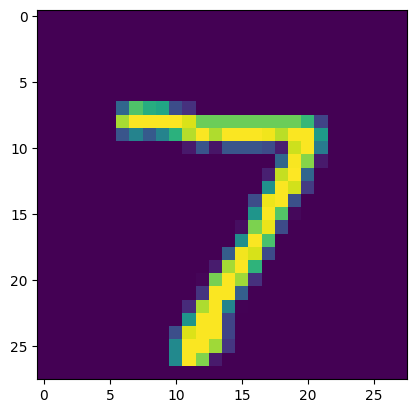

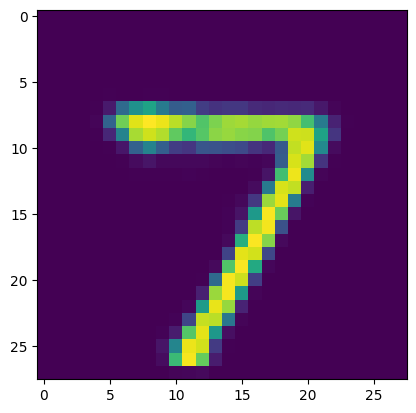

In [22]:
# Generate image from test dataset 
import matplotlib.pyplot as plt 

def show_image(x, idx):
    x = x.view(batch_size, 28, 28)
    fig = plt.figure()
    plt.imshow(x[idx].cpu())
    

model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(device)
        x_hat, _, _ = model(x)

        break 

    show_image(x, idx=0)
    show_image(x_hat, idx=0)